## Introduction



Here we give a set of generic instructions for analyzing demand for
food and nutrition.  Inputs include a datasets of consumption
quantities, consumption expenditures, household characteristics, and a
food conversion table.

The different datasets should be indexed as follows:

| Dataset|Indexed by|Columns|
|---|---|---|
| Expenditures|j,t,m|i|
| Consumption|j,t,m,u|i|
| HH Characteristics|j,t,m|k|
| FCT|i,u|n|
| RDI|n|k|

where `j` indexes households, `t` indexes periods, `m` indexes
markets, `i` indexes goods, `k` indexes different kinds of household
characteristics, `u` indexes different unit names, and `n` indexes
different nutrients.  Finally, any RDI (&ldquo;recommended daily intake&rdquo;)
tables should be indexed by nutrients, with columns corresponding to
characteristics of persons within the household (e.g., age & sex
categories).

Note that some countries have more than one dataframe of consumption,
distinguished by source; for example Malawi has consumption items
purchased as well as consumption items produced.  Here we focus on
consumption purchases, since one of our immediate aims is to infer
prices paid.



### Step 1: Acquire DataFrames



Here are addresses of google sheets for different dataframes for the
case of Niger:



In [1]:
#### Need private keys from json file (we're authenticating using "service accounts")
!gpg --batch --passphrase "noodle octopus" -d ../students.json.gpg > ../students.json

gpg: AES256 encrypted data
gpg: encrypted with 1 passphrase


In [2]:
# import sys
# sys.path.append('./Project3')


In [3]:
!pip install CFEDemands
!pip install dvc

  Using cached ruamel.yaml-0.17.4-py3-none-any.whl (101 kB)
  Using cached decorator-4.4.2-py2.py3-none-any.whl (9.2 kB)


  Attempting uninstall: ruamel.yaml
    Found existing installation: ruamel-yaml 0.15.87
ERROR: Cannot uninstall 'ruamel-yaml'. It is a distutils installed project and thus we cannot accurately determine which files belong to it which would lead to only a partial uninstall.


In [4]:
!pip install oauth2client
import oauth2client

In [5]:
from matplotlib import pyplot as plt

In [6]:
InputFiles = {'Expenditures':('1mZcHvSD55wGCicdqxbEnioE3AOXM_pVb6zVwHhtBzSk','Expenditures'),
              'Consumption':('1RT5AfbZbWx-CmNaOHLp7aD9qEjgjiBv8lZmPexuKEWg','Consumption'),
              'HH Characteristics':('1mZcHvSD55wGCicdqxbEnioE3AOXM_pVb6zVwHhtBzSk','HH Characteristics'),
              'FCT':('1a-pug3dN9TmNSILmIKx-g-h8ddqtQlD5UrD5Rd84BpY','Sheet2'),
              'FCT_Codes': ('1a-pug3dN9TmNSILmIKx-g-h8ddqtQlD5UrD5Rd84BpY', 'Sheet1')}


#### change the keys to match the ones for Uganda

Note that the food items for the FCT for Niger are **not** yet matched
up with food labels indexed by `i` in the expenditure and consumption datasets.



In [7]:
from eep153_tools import read_sheets
import numpy as np
import pandas as pd

def get_clean_sheet(key,json_creds,sheet=None):

    df = read_sheets(key,json_creds,sheet)
    df.columns = [c.strip() for c in df.columns.tolist()]

    df = df.loc[:,~df.columns.duplicated(keep='first')]   

    df = df.drop([col for col in df.columns if col.startswith('Unnamed')], axis=1)

    df = df.loc[~df.index.duplicated(), :]

    return df

# Get expenditures...
x = get_clean_sheet(InputFiles['Expenditures'][0],
                    json_creds='../students.json',
                    sheet=InputFiles['Expenditures'][1])

if 'm' not in x.columns:
    x['m'] = 1

x = x.set_index(['j','t','m'])
x.columns.name = 'i'

x = x.apply(lambda x: pd.to_numeric(x,errors='coerce'))
x = x.replace(0,np.nan)

# Get HH characteristics...
z = get_clean_sheet(InputFiles['HH Characteristics'][0],
                    json_creds='../students.json',
                    sheet=InputFiles['HH Characteristics'][1])

if 'm' not in z.columns:
    z['m'] = 1

z = z.set_index(['j','t','m'])
z.columns.name = 'k'

z = z.apply(lambda x: pd.to_numeric(x,errors='coerce'))

# Get purchased consumption quantities
q = get_clean_sheet(InputFiles['Consumption'][0],
                    json_creds='../students.json',
                    sheet=InputFiles['Consumption'][1])

if 'm' not in q.columns:
    q['m'] = 1

q = q.set_index(['j','t','m','u'])
q.columns.name = 'i'

q = q.apply(lambda x: pd.to_numeric(x,errors='coerce'))
q = q.replace(0,np.nan)
q = q.loc[~q.index.duplicated(), :]

fct = get_clean_sheet(InputFiles['FCT'][0],
                    json_creds='../students.json',
                    sheet=InputFiles['FCT'][1])

#### This bit peculiar to Niger FCT #####
#fct = fct.loc[fct.Code.str.len()==6]
#fct = fct.set_index('Code')
#fct.columns = [v.replace('\n',' ') for v in fct.columns]
########################################

fct.index.name = 'i'

fct = fct.apply(lambda x: pd.to_numeric(x,errors='coerce'))

In [8]:
fct2 = get_clean_sheet(InputFiles["FCT_Codes"][0],
                      json_creds = '../students.json',
                      sheet = InputFiles["FCT_Codes"][1])

fct2 = fct2[["Nutrition", "CODE"]]
fct2 = fct2[fct2["CODE"] != 'NA'].reset_index(drop = True)
fct2 = fct2[fct2["CODE"] != 'N/A'].reset_index(drop = True)
fct2 = fct2.rename(columns = {"Nutrition": "Uganda Food"})
fct2["CODE"] = pd.to_numeric(fct2["CODE"], errors='coerce')
fct2.head()

,Uganda Food,CODE
0,Matooke(others),5001
1,avocado,29110
2,beans dry,806001
3,beans fresh,806001
4,beef,811022


### Step 2: Estimate Demand System



Here, use data on log *expenditures* and household characteristics to
create a CFEDemand `result`.



In [9]:
import cfe

result = cfe.Result(y=np.log(x),z=z)

# Estimates most things (not counting std errors for betas).
xhat = result.get_predicted_expenditures() 

betas = result.get_beta(as_df=True).sort_values(ascending=False) # Check sanity...
betas

i
sweet bananas                         0.648765
coffee                                0.632619
passion fruits                        0.592344
oranges                               0.578709
bread                                 0.568417
fresh milk                            0.567437
mangoes                               0.516429
cooking oil                           0.483203
tomatoes                              0.471213
expenditure in restaurants on food    0.460684
dodo                                  0.452957
sugar                                 0.445207
other vegetables                      0.442311
margarine,butter                      0.433705
onions                                0.433037
rice                                  0.430074
soda                                  0.426924
eggs                                  0.420556
fresh fish                            0.412433
irish potatoes                        0.388275
beef                                  0.384351
beans fresh

In [10]:
betas.index

Index(['sweet bananas', 'coffee', 'passion fruits', 'oranges', 'bread',
       'fresh milk', 'mangoes', 'cooking oil', 'tomatoes',
       'expenditure in restaurants on food', 'dodo', 'sugar',
       'other vegetables', 'margarine,butter', 'onions', 'rice', 'soda',
       'eggs', 'fresh fish', 'irish potatoes', 'beef', 'beans fresh',
       'matooke_1', 'ground nuts pounded', 'goat meat', 'cabbages',
       'maize cobs', 'dry/smoked fish', 'tea', 'chicken', 'cassava fresh',
       'maize flour', 'beans dry', 'millet', 'sweet potatoes fresh', 'salt',
       'cassava dry/flour'],
      dtype='object', name='i')

In [11]:
from matplotlib import cm
viridis = cm.get_cmap('inferno_r', 40)

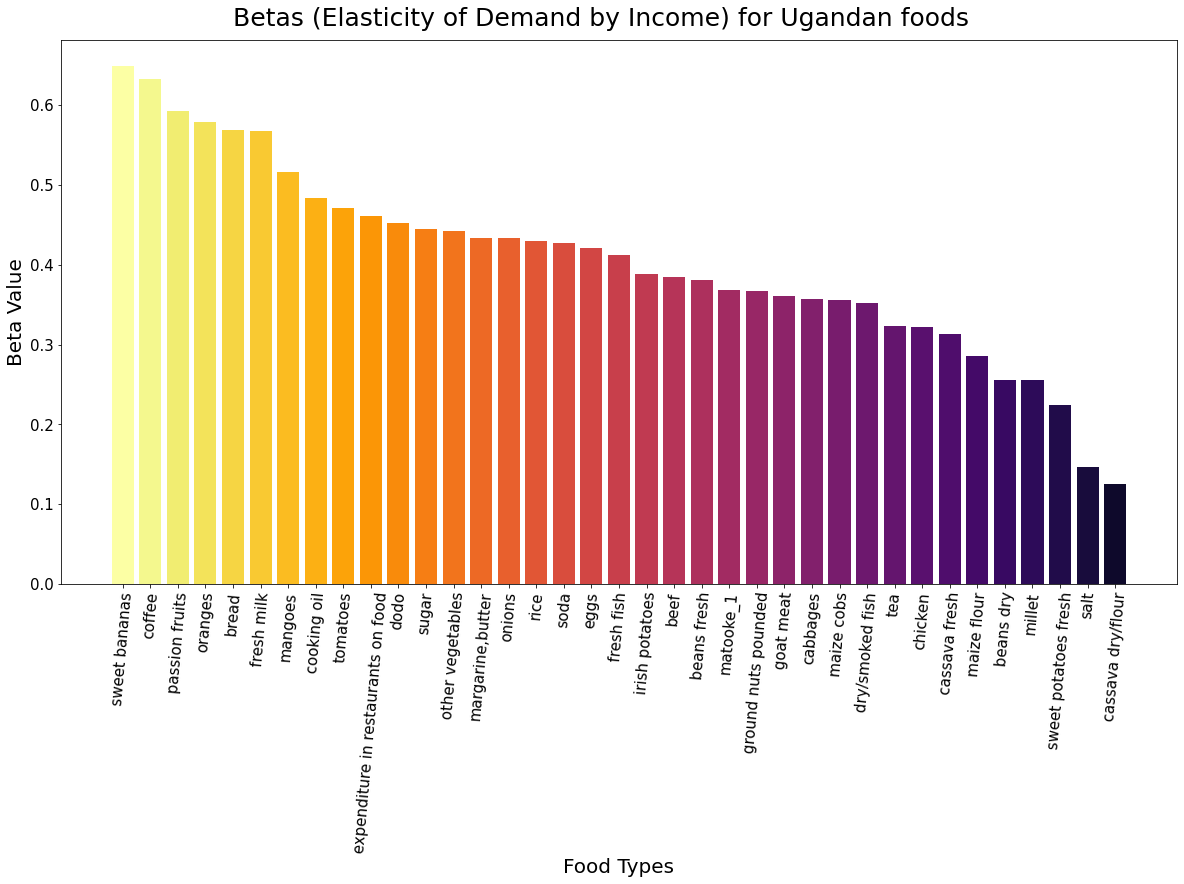

In [12]:
plt.figure(figsize=(20,10))
plt.figtext(.5, .9, "Betas (Elasticity of Demand by Income) for Ugandan foods", fontsize = 25, ha = 'center')
plt.xlabel("Food Types", fontsize = 20)
plt.ylabel("Beta Value", fontsize = 20)
plt.bar(betas.index, betas, color = viridis.colors[:])
plt.yticks(size = 15)
plt.xticks(rotation = 85, size = 15);

### Step 3: Infer prices



Next, we divide predicted expenditures by actual quantities to get
prices, then choose prices corresponding to some units (e.g.,
kilograms) we can map into the  FCT.



In [13]:
q

i                                            Matooke(cluster)  \
j            t    m u                                           
1.013000e+09 2005 1 Bottle (300 ml)                       NaN   
                    Bottle (500 ml)                       NaN   
                    Fish - Whole (1   2 kg)               NaN   
                    Kilogram (kg)                         NaN   
                    Litre                                 NaN   
...                                                       ...   
3.020000e+16 2011 1 Kilogram (kg)                         NaN   
                    Litre                                 NaN   
                    Packet (100 g)                        NaN   
                    Piece-Big                             NaN   
                    Piece-Small                           NaN   

i                                            Matooke(others)  avocado  \
j            t    m u                                                   
1.013000e+09 2005 1 Bottle (300 ml)                      NaN      NaN   
                    Bottle (500 ml)                      NaN      NaN   
                    Fish - Whole (1   2 kg)              NaN      NaN   
                    Kilogram (kg)                        NaN      NaN   
                    Litre                                NaN      NaN   
...                                                      ...      ...   
3.020000e+16 2011 1 Kilogram (kg)                        NaN      NaN   
                    Litre                                NaN      NaN   
                    Packet (100 g)                       NaN      NaN   
                    Piece-Big                            NaN      NaN   
                    Piece-Small                          NaN      NaN   

i                                            beans dry  beans fresh  beef  \
j            t    m u                                                       
1.013000e+09 2005 1 Bottle (300 ml)                NaN          NaN   NaN   
                    Bottle (500 ml)                NaN          NaN   NaN   
                    Fish - Whole (1   2 kg)        NaN          NaN   NaN   
                    Kilogram (kg)                  NaN          NaN   2.0   
                    Litre                          NaN          NaN   NaN   
...                                                ...          ...   ...   
3.020000e+16 2011 1 Kilogram (kg)                  NaN          NaN   NaN   
                    Litre                          NaN          NaN   NaN   
                    Packet (100 g)                 NaN          NaN   NaN   
                    Piece-Big                      NaN          NaN   NaN   
                    Piece-Small                    NaN          NaN   NaN   

i                                            beer  bread  cabbages  carrots  \
j            t    m u                                                         
1.013000e+09 2005 1 Bottle (300 ml)           NaN    NaN       NaN      NaN   
                    Bottle (500 ml)           2.0    NaN       NaN      NaN   
                    Fish - Whole (1   2 kg)   NaN    NaN       NaN      NaN   
                    Kilogram (kg)             NaN    NaN       NaN      NaN   
                    Litre                     NaN    NaN       NaN      NaN   
...                                           ...    ...       ...      ...   
3.020000e+16 2011 1 Kilogram (kg)             NaN    NaN       NaN      NaN   
                    Litre                     NaN    NaN       NaN      NaN   
                    Packet (100 g)            NaN    NaN       NaN      NaN   
                    Piece-Big                 NaN    NaN       NaN      NaN   
                    Piece-Small               NaN    NaN       NaN      NaN   

i                                            ...  simsim  soda  sorghum  \
j            t    m u                        ...                          
1.013000e+09 2005 1 Bott

In [14]:
xhatdf = xhat.to_dataframe('').unstack('i')
xhatdf.columns = xhatdf.columns.droplevel(0)

phat = (xhatdf/q).squeeze()

phat = phat.xs('Kilogram (kg)',level='u').groupby(['t','m']).median().dropna(how='all')


In [15]:
phat

,i,Matooke(cluster),Matooke(others),avocado,beans dry,beans fresh,beef,beer,bread,cabbages,carrots,...,simsim,soda,sorghum,sugar,sweet bananas,sweet potatoes dry,sweet potatoes fresh,tea,tomatoes,watermelon
t,m,,,,,,,,,,,,,,,,,,,,,
2005,1,NaN,NaN,NaN,1010.349705,1108.825008,2750.664123,NaN,1259.526369,NaN,NaN,...,NaN,NaN,NaN,1766.118809,NaN,NaN,NaN,800.224385,837.346353,NaN
2010,1,NaN,NaN,NaN,2211.560878,2140.970283,6065.723169,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3059.700959,NaN,NaN,NaN,1203.185271,823.816811,NaN
2011,1,NaN,NaN,NaN,2176.739962,2397.890994,7669.750456,NaN,3509.997007,NaN,NaN,...,NaN,NaN,NaN,3718.868398,2772.48029,NaN,NaN,1354.923453,1701.094476,NaN


### Step 4: Predicting Positive Consumption



An issue with our assessment of fit is that we *predicted* that every
household would consume positive quantitites of every good, and in
making our assessment we ignored the (many) cases in which in fact the
household had zero expenditures on that good.  

Here we&rsquo;re going to go back and use similar framework to try and
estimate the probability with which we&rsquo;ll observe zero expenditures
as a function of &lambda;, prices, and household characteristics.



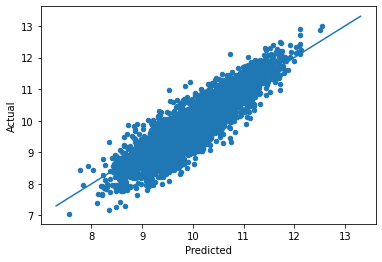

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.cm as cm

zeros_r = cfe.Result(y=(0.+(result.y>0)),z=result.z)
weights = zeros_r.get_predicted_log_expenditures()

# Truncate to make weights live in [0,1]
weights = weights.where((weights<1) + np.isnan(weights),1).where((weights>0) + np.isnan(weights),0)

xbar = np.exp(result.y).sum(['m','i']).to_dataframe('xbar').replace(0,np.nan).squeeze()

# Calculate *expected* predicted expenditures, to make unconditional on being positive
xhat = (weights*result.get_predicted_expenditures())
xsum = xhat.sum(['m','i']).to_dataframe('xhat').replace(0,np.nan).squeeze()

# Make dataframe of actual & predicted
df = pd.DataFrame({'Actual':np.log(xbar),'Predicted':np.log(xsum)})

df.plot.scatter(x='Predicted',y='Actual')

# Add 45 degree line
v = plt.axis()
vmin = np.max([v[0],v[2]])
vmax = np.max([v[1],v[3]])
plt.plot([vmin,vmax],[vmin,vmax])

### Step 5: Get predicted quantities



Now divide predicted expenditures by predicted prices to get predicted
quantities, and put back into a dataframe.



In [17]:
qhat = xhatdf.div(phat,axis=1)
qhat

i                         Matooke(cluster)  Matooke(others)  avocado  \
t    m j                                                               
2005 1 1013000201                      NaN              NaN      NaN   
       1013000202                      NaN              NaN      NaN   
       1013000204                      NaN              NaN      NaN   
       1013000206                      NaN              NaN      NaN   
       1013000209                      NaN              NaN      NaN   
...                                    ...              ...      ...   
2011 1 3010730012030203                NaN              NaN      NaN   
       3010730016100203                NaN              NaN      NaN   
       3010830020020503                NaN              NaN      NaN   
       3030230010040204                NaN              NaN      NaN   
       30211230006050302               NaN              NaN      NaN   

i                         beans dry  beans fresh      beef  beer     bread  \
t    m j                                                                     
2005 1 1013000201          1.457898     0.988164  1.418243   NaN  1.406403   
       1013000202               NaN          NaN       NaN   NaN       NaN   
       1013000204               NaN          NaN       NaN   NaN       NaN   
       1013000206               NaN          NaN       NaN   NaN       NaN   
       1013000209          1.388655     0.920467  1.365730   NaN  1.367352   
...                             ...          ...       ...   ...       ...   
2011 1 3010730012030203    1.686800     1.762397  1.340900   NaN  1.374230   
       3010730016100203    0.918664     0.681179  0.623621   NaN  0.506452   
       3010830020020503    1.081675     0.971677  0.738609   NaN  0.640682   
       3030230010040204         NaN          NaN       NaN   NaN       NaN   
       30211230006050302        NaN          NaN       NaN   NaN       NaN   

i                         cabbages  carrots  ...  simsim  soda  sorghum  \
t    m j                                     ...                          
2005 1 1013000201              NaN      NaN  ...     NaN   NaN      NaN   
       1013000202              NaN      NaN  ...     NaN   NaN      NaN   
       1013000204              NaN      NaN  ...     NaN   NaN      NaN   
       1013000206              NaN      NaN  ...     NaN   NaN      NaN   
       1013000209              NaN      NaN  ...     NaN   NaN      NaN   
...                            ...      ...  ...     ...   ...      ...   
2011 1 3010730012030203        NaN      NaN  ...     NaN   NaN      NaN   
       3010730016100203        NaN      NaN  ...     NaN   NaN      NaN   
       3010830020020503        NaN      NaN  ...     NaN   NaN      NaN   
       3030230010040204        NaN      NaN  ...     NaN   NaN      NaN   
       30211230006050302       NaN      NaN  ...     NaN   NaN      NaN   

i                            sugar  sweet bananas  sweet potatoes dry  \
t    m j                                                                
2005 1 1013000201         1.243823            NaN                 NaN   
       1013000202              NaN            NaN                 NaN   
       1013000204              NaN            NaN                 NaN   
       1013000206              NaN            NaN                 NaN   
       1013000209         1.112030            NaN                 NaN   
...                            ...            ...                 ...   
2011 1 3010730012030203   1.294175       0.933845                 NaN   
       3010730016100203   0.526774       0.265285                 NaN   
       3010830020020503   0.665652       0.360687                 NaN   
       3030230010040204        NaN            NaN                 NaN   
       30211230006050302       NaN            NaN                 NaN   

i                         sweet potatoes fresh       tea  tomatoes  watermelon  
t    m j                                 

### Step 6: Map predicted quantities into nutrients



May need some work to clean up the FCT, and create food names/indices
corresponding to the `i` index in `qhat`.



In [18]:
print(pd.Series(xhat.coords['i']).to_markdown())

|    | 0                                  |
|---:|:-----------------------------------|
|  0 | beans dry                          |
|  1 | beans fresh                        |
|  2 | beef                               |
|  3 | bread                              |
|  4 | cabbages                           |
|  5 | cassava dry/flour                  |
|  6 | cassava fresh                      |
|  7 | chicken                            |
|  8 | coffee                             |
|  9 | cooking oil                        |
| 10 | dodo                               |
| 11 | dry/smoked fish                    |
| 12 | eggs                               |
| 13 | expenditure in restaurants on food |
| 14 | fresh fish                         |
| 15 | fresh milk                         |
| 16 | goat meat                          |
| 17 | ground nuts pounded                |
| 18 | irish potatoes                     |
| 19 | maize cobs                         |
| 20 | maize flour              

| Niger Labels|WAFCT Codes|
|---|---|
| Baobab leaves|04<sub>001</sub>|
| Bean fritters|03<sub>054</sub>|
| Beans|03<sub>022</sub>|
| Beef|07<sub>014</sub>|
| Biscuit|01<sub>188</sub>|
| Bowl of millet with milk|01<sub>174</sub>|
| Bowl of millet without milk|01<sub>167</sub>|
| Bread|01<sub>047</sub>|
| Cakes|01<sub>187</sub>|
| Cassava tuber|02<sub>021</sub>|
| Cigarette||
| Coffee in cans|12<sub>009</sub>|
| Cola nut|06<sub>018</sub>|
| Corn|04<sub>109</sub>|
| Corn fritters|01<sub>123</sub>|
| Cornstarch||
| Curd|10<sub>028</sub>|
| Dates|05<sub>031</sub>|
| Dry okra|04<sub>077</sub>|
| Eggs|08<sub>001</sub>|
| Fresh Okra|04<sub>017</sub>|
| Fresh Onion|04<sub>018</sub>|
| Fresh fish|09<sub>060</sub>|
| Fresh pepper|04<sub>049</sub>|
| Fresh tomato|04<sub>021</sub>|
| Fruit juice|12<sub>013</sub>|
| Goat meat|07<sub>069</sub>|
| Groundnut cake|03<sub>012</sub>|
| Juice powder||
| Maggi cube||
| Malahya||
| Millet|01<sub>095</sub>|
| Mutton|07<sub>004</sub>|
| Orange|05<sub>016</sub>|
| Other citrus||
| Other spices||
| Palm oil|11<sub>007</sub>|
| Pasta|01<sub>077</sub>|
| Peanut butter|06<sub>023</sub>|
| Peanut oil|11<sub>003</sub>|
| Pimento||
| Potato|02<sub>009</sub>|
| Poultry|08<sub>010</sub>|
| Powdered milk|10<sub>002</sub>|
| Rice|01<sub>065</sub>|
| Rice &tomato sauce||
| Rice cowpea|03<sub>143</sub>|
| Salad||
| Salt|13<sub>015</sub>|
| Soft Drinks|12<sub>024</sub>|
| Soumbala|03<sub>042</sub>|
| Squash|04<sub>051</sub>|
| Sugar|13<sub>002</sub>|
| Sugar cane||
| Sweet banana|05<sub>048</sub>|
| Sweet potato|02<sub>049</sub>|
| Tea bag|12<sub>008</sub>|
| Tomato paste|04<sub>066</sub>|
| Yam tuber|02<sub>019</sub>|
| Yodo||
| Yogurt|10<sub>005</sub>|

These particular clean-ups are peculiar to our Ugandan FCT.



In [19]:
i_to_fct = fct2.set_index("Uganda Food").squeeze().to_dict()

myq = qhat.rename(columns=i_to_fct)
keep_columns = myq.columns.intersection(i_to_fct.values())
myq = myq[keep_columns]
myq = myq.groupby("i", axis = 1).sum()

# Drop goods with no obs, households with no goods
myq = myq.dropna(how='all',axis=1).dropna(how='all')

# Create version of fct with just foods in myq
#fct.set_index("food_code")
myfct=fct[fct['food_code'].isin(myq.columns)].drop(columns = {'food_description', 'food_state', 'food_state_code',
       'fct_source', 'fct_source_code', 'fct_source_descr',
       'water_source_descr', 'retention_source', 'retention_source_code',
       'retention_source_descr', 'food_group', 'food_group_code'}) # Drop columns which aren't nutrients

myfct.head()

,food_code,water_g,dry_matter_g,energy_kcal,protein_g,lipid_total_g,carbohydrate_g,fiber_g,calcium_mg,iron_mg,...,folic_acid_mcg,folate_food_mcg,folate_dfe_mcg,vit_b12_mcg,vit_a_iu,vit_a_rae_mcg,retinol_mcg,alpha_carot_mcg,beta_carot_mcg,beta_crypt_mcg
i,,,,,,,,,,,,,,,,,,,,,
5,1006,45.2,54.8,224,5.7,2.9,45.5,4.0,4,1.7,...,0,10,10,0.0,125,6,0,37,57,0
14,1015,2.5,97.5,397,10.2,5.1,80.9,8.0,8,2.8,...,0,14,14,0.0,210,11,0,62,95,0
15,1021,57.9,42.1,172,4.4,2.2,34.9,4.0,3,1.3,...,0,12,12,0.0,0,0,0,0,0,0
23,1041,11.3,88.7,369,7.3,1.8,79.2,4.0,3,1.1,...,0,30,30,0.0,3,0,0,0,1,1
40,1305,36.4,63.6,266,7.6,3.3,50.6,2.0,151,3.7,...,86,25,171,0.0,0,0,0,0,0,0


In [20]:
len(myfct.index)

44

In [21]:
#make the food codes the indexes so its easier to join
fct2 = fct2.set_index("CODE")
myfct = myfct.set_index("food_code")

Before this will work, need columns of myq to match indices of myfct.



In [22]:
myfct.index = myfct.index.astype(str)

In [23]:
myq.columns = myq.columns.astype(str)

In [24]:
## drop this column (9176 = mangoes) until we can figure out why it doesn't show up in myfct.index as well
myq = myq.drop(columns = {"9176"})

In [25]:
myq.columns, myfct.index, np.shape(myq), np.shape(myfct), np.shape(final_nutrients)

NameError: name 'final_nutrients' is not defined

In [ ]:
# This cell doesn't run yet. Still a rough draft
nutrients = myq@(myfct)
nutrients.mean()    # NB: Nutrients are for past /week/ for entire household.